> # Keras MobileNet Benchmark

In a previous benchmark we used a simple three layer ConvNet. This time we use a deeper MobileNet architecture on greyscale strokes. 

This kernel has three main components:

* MobileNet
* Fast and memory efficient Image Generator with temporal 
* Full training & submission with Kaggle Kernel

I did some paramer search but it should not be hard to improve the current score.

## Setup
Import the necessary libraries and a few helper functions.

In [2]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import math
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sys
sys.path.append("../input/mytorchpackages/")
sys.path.append("../input/seg-models/")
import random
random.seed(8)
np.random.seed(8)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
from keras.models import Sequential, Model
from keras.initializers import he_normal, he_uniform, glorot_normal, glorot_uniform, VarianceScaling
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Input
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

In [21]:
DP_DIR1 = '../input/myshuffled-csvs/'
DP_DIR2= '../input/myshuffled-csvs2/'
DP_DIR3 = '../input/myshuffled-csvs3/'
DP_DIR4= 'E:/quick_draw/train_k/'
INPUT_DIR = 'E:/quick_draw/train_k/'

BASE_SIZE = 256
NCSVS = 50
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)
def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [4]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

In [18]:
STEPS = 3850
EPOCHS = 6
size = 64
batchsize = 512

In [11]:
# load and shuffle filenames
#folder1 = '../input/myshuffled-csvs'
#filenames1 = os.listdir(folder1)
#folder2 = '../input/myshuffled-csvs2'
#filenames2 = os.listdir(folder2)
#folder3 = '../input/myshuffled-csvs3'
#filenames3 = os.listdir(folder3)
folder4 = 'E:/quick_draw/train_k'
filenames4 = os.listdir(folder4)
filenames = filenames4 #filenames1+filenames2+filenames3+filenames4
#filenames.remove('__output__.json')
#filenames.remove('__results__.html')
#filenames.remove('custom.css')
trainn = pd.DataFrame({'myfiles': filenames})
print(trainn.head())
from sklearn.model_selection import KFold
n_split=9
skf=KFold(n_splits=n_split, shuffle = True, random_state=1337)
for i,(trdex,valdex) in enumerate(skf.split(X=trainn.myfiles.values)):
    if (i!=0):
        continue
    seeder = i
    print('Training fold %d \n' % i)
    train_filenames = trainn.myfiles.values[trdex]
    valid_filenames = trainn.myfiles.values[valdex]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))


            myfiles
0   train_k0.csv.gz
1   train_k1.csv.gz
2  train_k10.csv.gz
3  train_k11.csv.gz
4  train_k12.csv.gz
Training fold 0 

n train samples 86
n valid samples 11


In [12]:
valid_filenames

array(['train_k10.csv.gz', 'train_k19.csv.gz', 'train_k24.csv.gz',
       'train_k31.csv.gz', 'train_k37.csv.gz', 'train_k38.csv.gz',
       'train_k50.csv.gz', 'train_k54.csv.gz', 'train_k56.csv.gz',
       'train_k79.csv.gz', 'train_k85.csv.gz'], dtype=object)

In [13]:
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras import backend as K
seeder = 0

def squeeze_excite_block(input, ratio=4):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer=he_normal(seed = seeder+20), use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer=he_normal(seed = seeder+20), use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [14]:
path1 = '../input/fpnet-resnet18-allchannel4-fold0/dl_model0.h5'
attention_module = 'cbam_block'
from xception_padding import Xception
from linknet_models import Linknet
from deeplabv3_bis  import Deeplabv3
from pspnet_models import PSPNet
from fpn_models import FPN
from attention_modules import attach_attention_module
#model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
img_input = Input(shape=(size, size, 3))
#inputs = Concatenate()([img_input, img_input, img_input])
model = FPN(backbone_name='resnet18', input_tensor=img_input, input_shape=(200, 200, 3))
model.summary()
out1 = model.layers[-7].output
out2 = model.get_layer("conv_block_relu").output
if attention_module is not None:
    out2 = attach_attention_module(out2, attention_module)
out = keras.layers.add([out1, out2])
out = Activation('relu')(out)
#out = squeeze_excite_block(out)
out = GlobalAveragePooling2D()(out)
out = Dense(NCATS, activation = 'softmax')(out)
model = Model(inputs=img_input, outputs=out, name='nn_zero')
model.load_weights(path1)
model.compile(optimizer=Adam(lr=0.000125), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
#print(model.summary())

ModuleNotFoundError: No module named 'xception_padding'

## Training with Image Generator

In [15]:
def partition_strokes(strokes, num_partitions):
    total_num_points = sum([len(s[0]) for s in strokes])
    partition_num_points = math.ceil(total_num_points / num_partitions)

    partitions = []

    current_partition = []
    current_partition_points = 0
    for s, stroke in enumerate(strokes):
        current_partition.append(stroke)
        current_partition_points += len(stroke[0])
        if current_partition_points >= partition_num_points or s == len(strokes) - 1:
            partitions.append(current_partition)
            current_partition = []
            current_partition_points = 0

    for _ in range(len(partitions), num_partitions):
        partitions.append([])

    return partitions


def draw_strokes(strokes, size=256, line_width=7, padding=10, fliplr=False):
    draw_size = 256
    scale_factor = (draw_size - 2 * padding) / draw_size

    image = np.full((draw_size, draw_size), 255, dtype=np.uint8)

    stroke_colors = range(0, 240, 40)

    for s, stroke in enumerate(strokes):
        stroke_color = stroke_colors[s % len(stroke_colors)]
        for i in range(len(stroke[0]) - 1):
            x0 = int(scale_factor * stroke[0][i]) + padding
            y0 = int(scale_factor * stroke[1][i]) + padding
            x1 = int(scale_factor * stroke[0][i + 1]) + padding
            y1 = int(scale_factor * stroke[1][i + 1]) + padding
            if fliplr:
                x0 = draw_size - x0
                x1 = draw_size - x1
            cv2.line(image, (x0, y0), (x1, y1), stroke_color, line_width)

    if draw_size != size:
        image = cv2.resize(image, (size, size), interpolation=cv2.INTER_AREA)

    return image


def merge_stroke_drawings(drawings):
    merged_drawing = np.full(drawings[0].shape, 255, dtype=np.uint8)
    for drawing in drawings:
        merged_drawing[drawing != 255] = drawing[drawing != 255]
    return merged_drawing


def draw_temporal_strokes(strokes, size=256, line_width=7, padding=10, fliplr=False, extended_channels=False):
    draw_size = 256
    scale_factor = (draw_size - 2 * padding) / draw_size

    stroke_colors = range(0, 240, 40)

    partition_images = []

    stroke_partitions = partition_strokes(strokes, 3)
    stroke_color_index = 0
    for stroke_partition in stroke_partitions:
        image = np.full((draw_size, draw_size), 255, dtype=np.uint8)
        partition_images.append(image)

        for stroke in stroke_partition:
            stroke_color = stroke_colors[stroke_color_index % len(stroke_colors)]
            stroke_color_index += 1
            for i in range(len(stroke[0]) - 1):
                x0 = int(scale_factor * stroke[0][i]) + padding
                y0 = int(scale_factor * stroke[1][i]) + padding
                x1 = int(scale_factor * stroke[0][i + 1]) + padding
                y1 = int(scale_factor * stroke[1][i + 1]) + padding
                if fliplr:
                    x0 = draw_size - x0
                    x1 = draw_size - x1
                cv2.line(image, (x0, y0), (x1, y1), stroke_color, line_width)

    if draw_size != size:
        partition_images = [cv2.resize(i, (size, size), interpolation=cv2.INTER_AREA) for i in partition_images]

    final_images = []
    if extended_channels:
        final_images.extend(partition_images)
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1]]))
        final_images.append(merge_stroke_drawings([partition_images[1], partition_images[2]]))
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1], partition_images[2]]))
    else:
        final_images.append(partition_images[0])
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1]]))
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1], partition_images[2]]))

    return np.array(final_images)

In [16]:
import threading

class ThreadSafeIterator:

    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """

    def g(*args, **kwargs):
        return ThreadSafeIterator(f(*args, **kwargs))

    return g
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
        
@threadsafe_generator
def image_generator_xd(size, batchsize, filenames, lw=6, time_color=True, augment = False):
    while True:
        for filename in filenames:
            if os.path.exists(DP_DIR1 + filename):
                for df in pd.read_csv(DP_DIR1 + filename, chunksize=batchsize):
                    df['drawing'] = df['drawing'].apply(ast.literal_eval)
                    x = np.zeros((len(df), size, size, 3))
                    for i, raw_strokes in enumerate(df.drawing.values):
                        fliplr = False
                        padding = 10
                        if augment:
                            #if np.random.rand() < 0.5:
                            #    fliplr = True
                            if np.random.rand() < 0.2:
                                padding += np.random.randint(5, 10)
                        xi = draw_temporal_strokes(raw_strokes,  size=size, padding=padding, fliplr=fliplr)
                        xi = np.moveaxis(xi, 0, -1)
                        x[i,:, :, :] =xi
                    x = preprocess_input(x).astype(np.float32)
                    y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                    yield x, y
            elif os.path.exists(DP_DIR2 + filename):
                for df in pd.read_csv(DP_DIR2 + filename, chunksize=batchsize):
                    df['drawing'] = df['drawing'].apply(ast.literal_eval)
                    x = np.zeros((len(df), size, size, 3))
                    for i, raw_strokes in enumerate(df.drawing.values):
                        fliplr = False
                        padding = 10
                        if augment:
                            #if np.random.rand() < 0.5:
                            #    fliplr = True
                            if np.random.rand() < 0.2:
                                padding += np.random.randint(5, 10)
                        xi = draw_temporal_strokes(raw_strokes,  size=size, padding=padding, fliplr=fliplr)
                        xi = np.moveaxis(xi, 0, -1)
                        x[i, :, :, :] =xi
                    x = preprocess_input(x).astype(np.float32)
                    y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                    yield x, y
            elif os.path.exists(DP_DIR3 + filename):
                for df in pd.read_csv(DP_DIR3 + filename, chunksize=batchsize):
                    df['drawing'] = df['drawing'].apply(ast.literal_eval)
                    x = np.zeros((len(df), size, size, 3))
                    for i, raw_strokes in enumerate(df.drawing.values):
                        fliplr = False
                        padding = 10
                        if augment:
                            #if np.random.rand() < 0.5:
                            #    fliplr = True
                            if np.random.rand() < 0.2:
                                padding += np.random.randint(5, 10)
                        xi = draw_temporal_strokes(raw_strokes,  size=size, padding=padding, fliplr=fliplr)
                        xi = np.moveaxis(xi, 0, -1)
                        x[i, :, :, :] =xi
                    x = preprocess_input(x).astype(np.float32)
                    y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                    yield x, y
            else:
                for df in pd.read_csv(DP_DIR4 + filename, chunksize=batchsize):
                    df['drawing'] = df['drawing'].apply(ast.literal_eval)
                    x = np.zeros((len(df), size, size, 3))
                    for i, raw_strokes in enumerate(df.drawing.values):
                        fliplr = False
                        padding = 10
                        if augment:
                            #if np.random.rand() < 0.5:
                            #    fliplr = True
                            if np.random.rand() < 0.2:
                                padding += np.random.randint(5, 10)
                        xi = draw_temporal_strokes(raw_strokes,  size=size, padding=padding, fliplr=fliplr)
                        xi = np.moveaxis(xi, 0, -1)
                        x[i, :, :, :] =xi
                    x = preprocess_input(x).astype(np.float32)
                    y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                    yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [ ]:
#valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
#x_valid = df_to_image_array_xd(valid_df, size)
#y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
#print(x_valid.shape, y_valid.shape)
#print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

In [23]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize,filenames= train_filenames)
valid_datagen = image_generator_xd(size=size, batchsize=batchsize, filenames= valid_filenames)

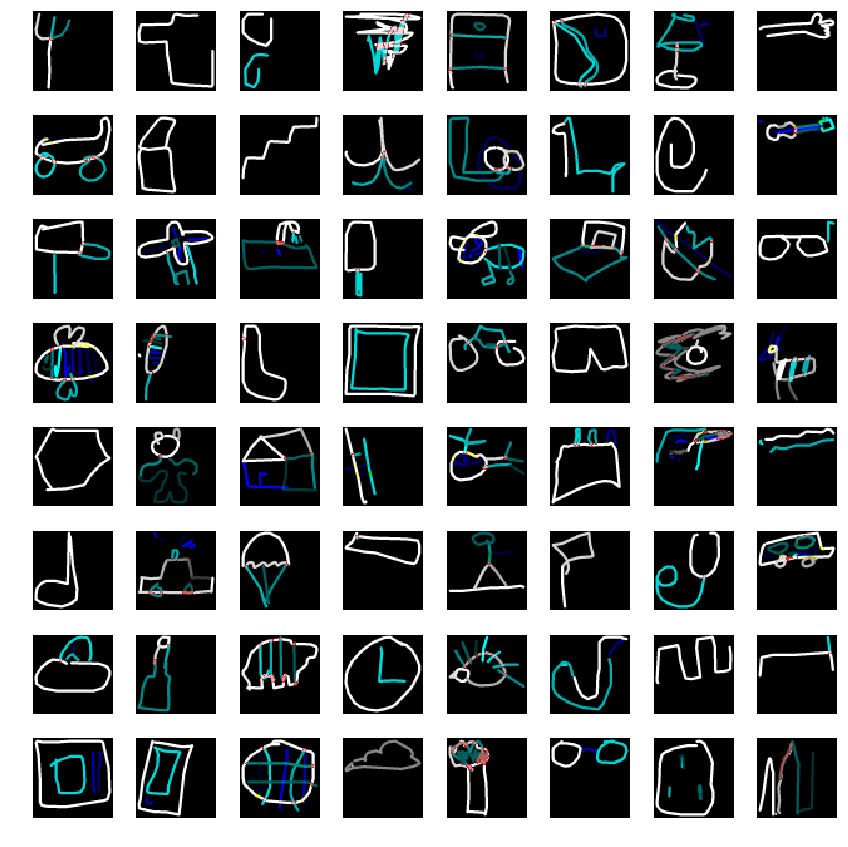

In [24]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, :] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [25]:
bst_model_path = 'dl_model0.h5'
callbacks = [ ModelCheckpoint(monitor='val_categorical_accuracy', filepath = bst_model_path, save_best_only=True, verbose=1, mode = 'max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=valid_datagen, validation_steps = STEPS/n_split,
    callbacks = callbacks
)
hists.append(hist)

TypeError: __init__() got an unexpected keyword argument 'min_delta'

In [ ]:
from keras.backend import eval
print(eval(model.optimizer.lr))

In [ ]:
bst_val_score = min(hist.history['val_loss'])
print("bst_val_loss", bst_val_score)

In [ ]:
bst_val_score = max(hist.history['val_categorical_accuracy'])
print("bst_val_categorical_accuracy", bst_val_score)

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))